# Accessibility Scores of NCR Barangays to Healthcare System

## Declarations

In [2]:
import pandas as pd
import geopandas as gpd
from access import Access, weights, Datasets
import access

## Data Import

In [6]:
ncr_boundary_pop = gpd.read_file('../data/analytics/ncr_boundary_pop.geojson', driver="GeoJSON")

In [9]:
ncr_boundary_pop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1691 entries, 0 to 1690
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   region           1691 non-null   object  
 1   city             1691 non-null   object  
 2   barangay         1691 non-null   object  
 3   population       1691 non-null   int64   
 4   brgy_index       1691 non-null   int64   
 5   brgy_index_city  1691 non-null   object  
 6   geometry         1691 non-null   geometry
dtypes: geometry(1), int64(2), object(4)
memory usage: 92.6+ KB


In [13]:
ncr_boundary_pop.head()

,region,city,barangay,population,brgy_index,brgy_index_city,geometry
0,Metropolitan Manila,Caloocan,Barangay 100,983,0,Barangay 100 | (Caloocan),"POLYGON ((120.99181 14.65265, 120.99107 14.653..."
1,Metropolitan Manila,Caloocan,Barangay 101,2517,1,Barangay 101 | (Caloocan),"POLYGON ((120.99307 14.65218, 120.99255 14.650..."
2,Metropolitan Manila,Caloocan,Barangay 102,1033,2,Barangay 102 | (Caloocan),"POLYGON ((120.99228 14.64971, 120.99199 14.649..."
3,Metropolitan Manila,Caloocan,Barangay 103,175,3,Barangay 103 | (Caloocan),"POLYGON ((120.98585 14.64703, 120.98582 14.648..."
4,Metropolitan Manila,Caloocan,Barangay 104,899,4,Barangay 104 | (Caloocan),"POLYGON ((120.98439 14.64707, 120.98434 14.648..."


In [7]:
ncr_hosp = gpd.read_file('../data/analytics/ncr_hosp.geojson', driver="GeoJSON")

In [10]:
ncr_hosp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   facility_name       155 non-null    object  
 1   service_capability  155 non-null    object  
 2   bed_capacity        155 non-null    int64   
 3   hospital_index      155 non-null    int64   
 4   potential           155 non-null    object  
 5   geometry            155 non-null    geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 7.4+ KB


In [14]:
ncr_hosp.head()

,facility_name,service_capability,bed_capacity,hospital_index,potential,geometry
0,A. ZARATE GENERAL HOSPITAL,Level 1,17,1691,No Potential,POINT (120.98052 14.46901)
1,ACEBEDO GENERAL HOSPITAL,Level 1,16,1692,No Potential,POINT (121.00509 14.71877)
2,ADVENTIST MEDICAL CENTER MANILA,Level 3,150,1693,High Potential,POINT (120.99527 14.55595)
3,AIR FORCE GENERAL HOSPITAL,Level 2,100,1694,No Potential,POINT (121.02001 14.51689)
4,ALABANG MEDICAL CENTER,Level 1,18,1695,No Potential,POINT (121.02448 14.42777)


In [11]:
travel_matrix = pd.read_csv('../data/analytics/travel_matrix.csv', index_col=0).reset_index()

In [12]:
travel_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262105 entries, 0 to 262104
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   brgy_index      262105 non-null  int64  
 1   hospital_index  262105 non-null  int64  
 2   duration        262105 non-null  float64
 3   potential       262105 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 8.0+ MB


In [15]:
travel_matrix.head()

,brgy_index,hospital_index,duration,potential
0,0,1691,2367.47,No Potential
1,1,1691,2271.67,No Potential
2,2,1691,2263.77,No Potential
3,3,1691,2230.33,No Potential
4,4,1691,2212.23,No Potential


## Accesibility Scores

API Documentation: https://pysal.org/access/index.html

In [16]:
brgy_hosp_access = Access(
    demand_df=ncr_boundary_pop,
    demand_index="brgy_index",
    demand_value="population",
    supply_df=ncr_hosp,
    supply_index="hospital_index",
    supply_value="bed_capacity",
    cost_df=travel_matrix,
    cost_origin="brgy_index",
    cost_dest="hospital_index",
    cost_name="duration", #duration is in seconds
    neighbor_cost_df=travel_matrix,
    neighbor_cost_origin="brgy_index",
    neighbor_cost_dest="hospital_index",
    neighbor_cost_name="duration"
)

In [17]:
def plot_access_measure(access_metric, reversed_color=False):
    ncr_map = (
        ncr_boundary_pop[["brgy_index", "geometry"]]
        .set_index("brgy_index")
        .join(brgy_hosp_access.access_df, how="inner")
    )
    base = ncr_map.plot(
        access_metric,
        legend=True,
        figsize=(15, 15),
        cmap="viridis_r" if reversed_color else "viridis", #In RAAM, lower is better
        markersize=0.5,
        alpha=1,
        vmin=ncr_map[access_metric].quantile(0.05),
        vmax=ncr_map[access_metric].quantile(0.95),
    )
    ncr_hosp.plot(ax=base, markersize=7, color="red")

### Gravity Model

In [18]:
gravity = weights.gravity(scale=60, alpha=-1)
brgy_hosp_access.weighted_catchment(name="gravity", weight_fn=gravity)

,gravity_bed_capacity
brgy_index,
0,1891.504776
1,2026.998471
2,2046.342067
3,2033.457538
4,2026.379123
...,...
1686,1262.674742
1687,906.523724
1688,1275.848754


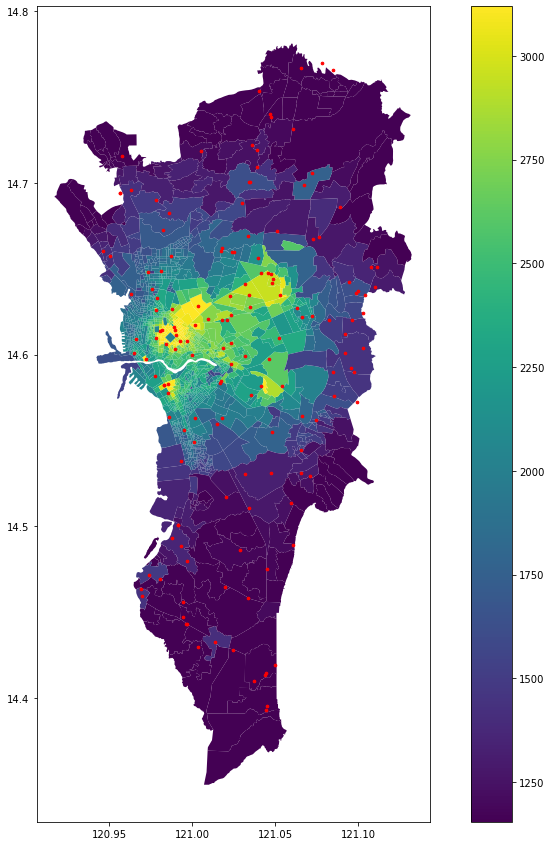

In [19]:
plot_access_measure("gravity_bed_capacity")

### Rational Agent Access Model (RAAM)

In [20]:
brgy_hosp_access.raam(name="raam15", tau=900) #15minutes buffer time

,raam15_bed_capacity
brgy_index,
0,1.497480
1,1.345352
2,1.350324
3,1.396273
4,1.394335
...,...
1686,1.971997
1687,2.348657
1688,2.100507


In [21]:
brgy_hosp_access.raam(name="raam30", tau=1800) #30minutes buffer time

,raam30_bed_capacity
brgy_index,
0,1.339412
1,1.208074
2,1.206568
3,1.222436
4,1.246992
...,...
1686,1.570583
1687,1.773469
1688,1.572297


In [22]:
brgy_hosp_access.access_df

,population,gravity_bed_capacity,raam15_bed_capacity,raam30_bed_capacity
brgy_index,,,,
0,983,1891.504776,1.497480,1.339412
1,2517,2026.998471,1.345352,1.208074
2,1033,2046.342067,1.350324,1.206568
3,175,2033.457538,1.396273,1.222436
4,899,2026.379123,1.394335,1.246992
...,...,...,...,...
1686,6940,1262.674742,1.971997,1.570583
1687,3400,906.523724,2.348657,1.773469
1688,55494,1275.848754,2.100507,1.572297


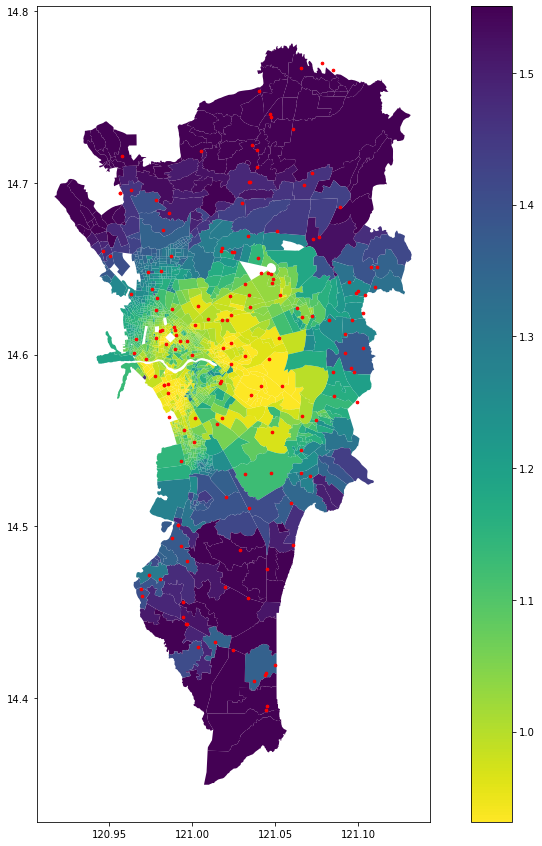

In [23]:
plot_access_measure("raam30_bed_capacity", reversed_color=True)

### Catchment Models (fca, two_stage_fca, enhance_two_stage_fca, three_stage_fca)

To use fca models for accessibility scores:
* perform spatial join of bed capacity for each barangay
* cost_df
    * recalculate travel time matrix for each pair of barangay
        * too costly (1691^1691 pairs)
        * alternatively euclidean distance may be used but may still be a costly operation.

---